In [2]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [6]:
# data_hor_disc = pd.read_excel("Data/DiscreteMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
# data_hor_cont = pd.read_excel("Data/ContinuousMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
# data_ver_disc = pd.read_excel("Data/DiscreteMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
# data_ver_cont = pd.read_excel("Data/ContinuousMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")

data_hor=pd.read_csv("Data/combined_data_hor.csv")
data_hor = data_hor.drop('Unnamed: 0', axis=1)

In [7]:
data_hor.columns

Index(['Pow_100_disc', 'Pow_100_cont', 'Pow_200_disc', 'Pow_200_cont',
       'Pow_300_disc', 'Pow_300_cont', 'Pow_400_disc', 'Pow_400_cont',
       'Pow_500_disc', 'Pow_500_cont', 'Pow_600_disc', 'Pow_600_cont',
       'Pow_700_disc', 'Pow_700_cont', 'Pow_800_disc', 'Pow_800_cont',
       'Pow_900_disc', 'Pow_900_cont', 'Pow_1000_disc', 'Pow_1000_cont',
       'Pow_1100_disc', 'Pow_1100_cont', 'Pow_1200_disc', 'Pow_1200_cont',
       'Pow_1300_disc', 'Pow_1300_cont', 'Pow_1400_disc', 'Pow_1400_cont',
       'Pow_1500_disc', 'Pow_1500_cont', 'Pow_1600_disc', 'Pow_1600_cont',
       'Pow_1700_disc', 'Pow_1700_cont', 'Pow_1800_disc', 'Pow_1800_cont',
       'Pow_1900_disc', 'Pow_1900_cont', 'Pow_2000_disc', 'Pow_2000_cont'],
      dtype='object')

In [8]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_hor.columns]
scaler = MinMaxScaler()

# perc=0.7


# # Splitting the dataset into train and test --> 70% in length is used for train
# df_train=data_hor_disc.head(int(len(data_hor_disc)*perc))
# df_test=data_hor_disc.head(int(len(data_hor_disc)*(1-perc)))

# scaled_train = scaler.fit_transform(df_train[power_list])
# scaled_test = scaler.transform(df_test[power_list])

# from sklearn.preprocessing import MinMaxScaler
# power_list = [i for i in data_hor_disc.columns]
# scaler = MinMaxScaler()

perc=0.7

# Splitting the dataset into train and test --> 70% in length is used for train
train_size = int(len(data_hor) * perc)
test_size = len(data_hor) - train_size
df_train = data_hor[0:train_size]
df_test = data_hor[train_size:len(data_hor)]

scaled_train = scaler.fit_transform(df_train[power_list])
scaled_test = scaler.transform(df_test[power_list])

In [9]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [10]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [11]:
LOOK_BACK=500
FORECAST_RANGE=20

## making the look_back according to the main frequency since the data are kindly periodic

n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30980, 500, 40)
(30980, 20, 40)
(12982, 500, 40)
(12982, 20, 40)


In [12]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [13]:
epochs = 50
batch_size = 32
validation = 0.1

In [14]:
checkpoint_filepath = 'improvementsModel_combinedData_20_mac/weights-improvement-{epoch:06d}-{val_loss:.6f}.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.005)

In [15]:
## Encoder-Decoder Model

model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='tanh', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/50


2023-01-13 22:45:59.866790: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


872/872 [==============================] - 159s 179ms/step - loss: 0.0599 - val_loss: 0.0464 - lr: 0.0010
Epoch 2/50
872/872 [==============================] - 1170s 1s/step - loss: 0.0397 - val_loss: 0.0366 - lr: 0.0010
Epoch 3/50
872/872 [==============================] - 3026s 3s/step - loss: 0.0318 - val_loss: 0.0342 - lr: 0.0010
Epoch 4/50
872/872 [==============================] - 258s 296ms/step - loss: 0.0285 - val_loss: 0.0331 - lr: 0.0010
Epoch 5/50
872/872 [==============================] - 1126s 1s/step - loss: 0.0261 - val_loss: 0.0325 - lr: 0.0010
Epoch 6/50
872/872 [==============================] - 1543s 2s/step - loss: 0.0244 - val_loss: 0.0319 - lr: 0.0010
Epoch 7/50
872/872 [==============================] - 839s 963ms/step - loss: 0.0230 - val_loss: 0.0316 - lr: 0.0010
Epoch 8/50
872/872 [==============================] - 1038s 1s/step - loss: 0.0218 - val_loss: 0.0318 - lr: 0.0010
Epoch 9/50
872/872 [==============================] - 1038s 1s/step - loss: 0.0209 - 

In [16]:
## CNN-LSTM Encoder - Decoder Model

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='tanh'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation='tanh', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='tanh')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

In [17]:
## Vector Output Model

input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv)
lstm = LSTM(100, return_sequences=True, activation='tanh')(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100, activation='tanh')(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='tanh')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

In [18]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='tanh')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

Text(0, 0.5, 'MAPE')

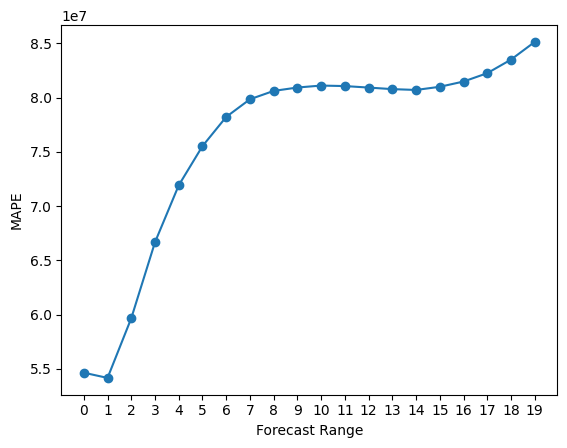

In [19]:
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
    time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mape = mape_(y_test_time_step[i], yhat_time_step[i])
    mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE')

In [20]:
for i in range(0, n_features):
    print('->', i)
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mae:', mae)
    mse = mse_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mse:', mse)
    mape = mape_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mape:', mape)

-> 0
mae: tf.Tensor(0.15277961, shape=(), dtype=float32)
mse: tf.Tensor(0.04898696, shape=(), dtype=float32)
mape: tf.Tensor(2520461.2, shape=(), dtype=float32)
-> 1
mae: tf.Tensor(0.08267301, shape=(), dtype=float32)
mse: tf.Tensor(0.015793359, shape=(), dtype=float32)
mape: tf.Tensor(725824.4, shape=(), dtype=float32)
-> 2
mae: tf.Tensor(0.2997723, shape=(), dtype=float32)
mse: tf.Tensor(0.23510893, shape=(), dtype=float32)
mape: tf.Tensor(36037296.0, shape=(), dtype=float32)
-> 3
mae: tf.Tensor(0.13435116, shape=(), dtype=float32)
mse: tf.Tensor(0.041132253, shape=(), dtype=float32)
mape: tf.Tensor(12.976975, shape=(), dtype=float32)
-> 4
mae: tf.Tensor(0.5412522, shape=(), dtype=float32)
mse: tf.Tensor(0.50703615, shape=(), dtype=float32)
mape: tf.Tensor(36749764.0, shape=(), dtype=float32)
-> 5
mae: tf.Tensor(0.20693126, shape=(), dtype=float32)
mse: tf.Tensor(0.118683696, shape=(), dtype=float32)
mape: tf.Tensor(2384080.5, shape=(), dtype=float32)
-> 6
mae: tf.Tensor(0.79658014, 

In [21]:
# This code looks like it's implementing a neural network for forecasting power consumption using an LSTM (Long Short-Term Memory) network. LSTM networks are a type of recurrent neural network (RNN) that are well-suited for time series forecasting tasks because they are able to capture long-term dependencies in data.

# Overall, the code seems to be implementing a standard process for training and evaluating an LSTM-based time series forecasting model:

# The data is loaded and preprocessed, including splitting it into training and test sets and scaling the features using the MinMaxScaler.

# The data is transformed into input/output sequences for the LSTM model using the "split_sequence" function.

# The LSTM model is defined and compiled using the Keras API.

# The model is fit on the training data using the "fit" method.

# The model is evaluated on the test data using the "evaluate_forecast" function, which computes mean absolute error (MAE), mean squared error (MSE), and mean absolute percentage error (MAPE).

In [22]:
# There are a few things that you could consider doing to improve the performance of this model:

# Increase the size of the training data. More data can often improve the accuracy of the model.

# Tune the model hyperparameters. There are a number of parameters that you can adjust in an LSTM model, such as the number of hidden units, the type of activation function, and the learning rate. You may be able to improve the model's performance by finding the optimal values for these parameters.

# Use regularization techniques. Overfitting is a common problem in neural network models, especially when working with small datasets. You can try adding dropout layers or weight regularization to the model to reduce overfitting and improve generalization.

# Experiment with different model architectures. There are many different ways to design an LSTM model, and different architectures may work better for different types of data. You can try adding additional layers or changing the number of hidden units to see if it improves the model's performance.

# Consider using a different type of model. While LSTMs are very effective for time series forecasting, they may not always be the best choice. Other types of models, such as Facebook Prophet or seasonal decomposition models, may work better for your specific problem.

# I hope these suggestions are helpful! Let me know if you have any questions or if you'd like further guidance.

In [23]:
def create_model(units, dropout_rate):
  model = Sequential()
  # Add layers to your model here
  model.add(Dense(units, input_shape=input_shape))
  model.add(Dropout(dropout_rate))
  # Add more layers as needed
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [24]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from joblib import Parallel, delayed
# from scikeras.wrappers import KerasRegressor

# Define the input shape
input_shape = (LOOK_BACK, n_features)

# Create the model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid
# param_grid = {
#     'batch_size': [16, 32, 64, 128, 256, 512],
#     'epochs': [10, 20, 30, 40, 50, 100, 200],
#     'units': [16, 32, 64, 128, 256, 512],
#     'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# }

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'units': [16, 32, 64],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1, verbose=1, pre_dispatch='2*n_jobs')

# Parallelize the grid search
# results = Parallel(n_jobs=-1, verbose=1)(delayed(grid_search.fit)(X_train, y_train) for i in range(num_repeats))

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test data
best_model = grid_search.best_estimator_
yhat = best_model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
yhat_inverse = scaler.inverse_transform(yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/var/folders/5v/snpvy65x6rx4rzv00_hsqsq80000gn/T/ipykernel_90715/2555976658.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
